In [4]:
import random
import warnings
from itertools import product
from typing import Iterable, Self

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import tqdm
from sklearn.datasets import load_breast_cancer
from torch.nn.utils.parametrizations import weight_norm
from torch.utils.data import random_split, DataLoader, Dataset
from torchvision import transforms

**Instruções gerais:** Sua submissão <u>deve</u> conter: 
1. Um "ipynb" com seu código e as soluções dos problemas
2. Uma versão pdf do ipynb

Caso você opte por resolver as questões de "papel e caneta" em um editor de $\LaTeX$ externo, o inclua no final da versão pdf do 'ipynb'--- submetendo um <u>único pdf</u>.

# Trabalho de casa 06: Redes neurais

**1.** O código abaixo baixa e carrega o banco de dados _CIFAR10_, que contém diversas imagens RGB de **10 classes distintas**. Além disso, os dados já estão separados em um objeto que provê batches de treino, teste e validação.

Também provemos um exemplo de como definir um modelo em _PyTorch_ (você é livre para modifica-lo e facilitar sua vida), bem como um exemplo de como carregar batches. **Treine uma CNN para resolver o problema --- fazendo uma busca de hiper-parâmetros razoável baseada no erro de validação.**

Consulte a documentação do _PyTorch_ para entender o que cada função na definição da CNN faz. Reporte os resultados do modelo escolhido no conjunto de teste, bem como suas curvas de aprendizado.

Além disso, mostre como os dados de entrada são transformados ao longo das camadas (plote as figuras intermerdiárias para alguns inputs da sua escolha) e comente. 

cpu
Files already downloaded and verified
Files already downloaded and verified


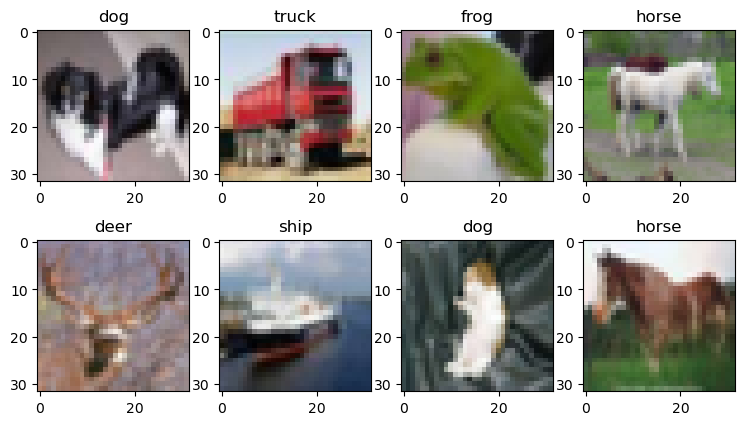

In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

# The batch size
#batch_size = 2048

transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

train_set = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True,
    transform=transform_train,
)
test_set = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True,
    transform=transform_test
)

#train_loader = DataLoader(
#    train_set, batch_size=batch_size, shuffle=True,
#    num_workers=2
#)
#test_loader = DataLoader(
#    test_set, batch_size=batch_size, shuffle=True,
#    num_workers=2
#)

train_set, val_set = random_split(train_set, [40000, 10000])

classes = (
    'plane', 'car', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
)

n_img = 8

f, ax = plt.subplots(2, 4, figsize=(9,5))
indices = np.random.choice(len(test_set), n_img)
images, labels = test_set.data[indices], [test_set.targets[i] for i in indices]

for i in range(n_img):
    ax[i%2, i//2].imshow(images[i])
    ax[i%2, i//2].set_title(classes[labels[i]])

warnings.filterwarnings("ignore", "TensorFloat32 tensor cores for float32 matrix multiplication")
warnings.filterwarnings("ignore", "Lazy modules are a new feature under heavy development")
warnings.filterwarnings("ignore", "Plan failed with a cudnnException:")

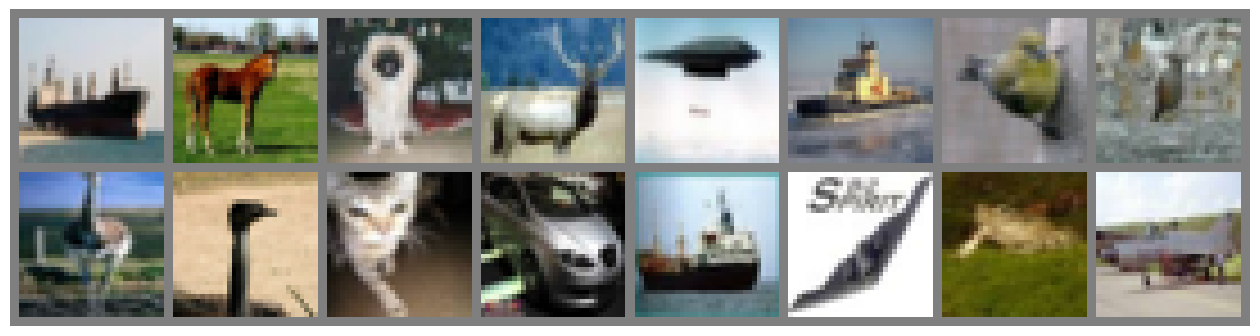

In [35]:
from torchvision import datasets, transforms, utils

n_img = 16
indices = np.random.choice(len(test_set), n_img)
images, labels = zip(*[test_set[i] for i in indices])
images = torch.stack(images)
# plot grid of 16 images with torchvision utils

from torchvision import datasets, transforms, utils
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(16, 16))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

# Plot the grid of images
imshow(utils.make_grid(images))

In [ ]:
from torchvision import datasets, transforms, utils
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(16, 16))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

model.eval()
cols, rows = 8, 8
with torch.no_grad():
    X = torch.Tensor(torch.normal(torch.zeros(cols * rows, 32 * 32 * 3),
                                  torch.ones(cols * rows, 32 * 32 * 3))).to(device)
    Y = model(X)
    samples = post_process(Y).cpu()

imshow(utils.make_grid(samples))


In [4]:
class CNN(nn.Sequential):
    def __init__(
        self,
        num_epochs: int = 10,
        batch_size: int = 128,
        lr: float = 1e-3,
        weight_decay = 0.01,
        dropout_p: float = 0.1,
        c1: int = 32,
        c2: int = 32,
        kernel_size: int = 7,
        l1: int = 64,
        l2: int = 64,
        output_dim: int = 10,
        seed: int | None = 42
    ) -> None:
        # Inicializa a rede neural
        super().__init__(
            nn.Conv2d(3, c1, kernel_size, padding="same"),
            nn.ReLU(),
            nn.BatchNorm2d(c1),
            nn.Conv2d(c1, c2, kernel_size, padding="same"),
            nn.ReLU(),
            nn.BatchNorm2d(c2),
            nn.MaxPool2d(2, 2),
            nn.Flatten(),
            nn.LazyLinear(l1),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            nn.Linear(l1, l2),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            nn.Linear(l2, output_dim)
        )
        self.criterion = nn.CrossEntropyLoss()
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.lr = lr
        self.weight_decay = weight_decay
        self.device = torch.device(device or ("cuda:0" if torch.cuda.is_available() else "cpu"))
        self.to(self.device)
        self.val_losses = []
        self.train_losses = []
        self.accuracies = []
        self.seed = seed
        self.set_seed()
        self.optimizer = torch.optim.Adam(
            self.parameters(), lr=self.lr, weight_decay=self.weight_decay
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Exclui a loss
        for module in list(self)[:-1]:
            x = module(x)
        return x

    def set_seed(self, seed: int | None = None) -> None:
        """Define a seed para reprodução dos resultados."""
        seed = seed or self.seed
        if seed is None:
            return
        torch.manual_seed(self.seed)
        np.random.seed(self.seed)
        random.seed(self.seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed_all(self.seed)

    def get_accuracy_and_loss(self, data: DataLoader | Dataset) -> tuple[float, float]:
        """
        Calcula a acurácia e a perda da rede neural.

        Parâmetros
        ----------
        data : torch.utils.data.DataLoader ou torch.utils.data.Dataset
            Conjunto de dados.

        Retorna
        -------
        tuple[float, float]
            Acurácia e perda da rede neural.
        """
        self.eval()
        correct = 0
        steps = 0
        total = 0
        current_loss = 0
        loader = (
            data if isinstance(data, DataLoader) else
            DataLoader(data, batch_size=self.batch_size, shuffle=False, num_workers=8)
        )
        with torch.no_grad():
            for inputs, labels in loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                outputs = self(inputs)
                # Acurácia
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                # Perda
                current_loss += self.criterion(outputs, labels).item()
                steps += 1

        return correct / total, current_loss / steps

    def train_model(self, train_set: Dataset, val_set: Dataset) -> Iterable[tuple[float, float]]:
        """
        Treina a rede neural.

        Parâmetros
        ----------
        train_set : torch.utils.data.Dataset
            Conjunto de dados de treino.
        val_set : torch.utils.data.Dataset
            Conjunto de dados de validação.

        Yields
        -------
        tuple[float, float]
            Acurácia e perda no conjunto de validação.
        """
        train_loader = DataLoader(train_set, batch_size= self.batch_size, shuffle=True,num_workers=6)
        val_loader = DataLoader(val_set, batch_size= self.batch_size, shuffle=True,num_workers=6)

        for _ in range(self.num_epochs):
            self.train()
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                #self.optimizer.zero_grad()

                # Forward
                outputs = self(inputs)
                loss = self.criterion(outputs, labels)

                # Backward
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                self.train_losses.append(loss.item())

            acc, loss = self.get_accuracy_and_loss(val_loader)
            self.accuracies.append(acc)
            self.val_losses.append(loss)
            yield acc, loss

    def fit(self, train_data: Dataset, val_data: Dataset, show_progress: bool = True) -> Self:
        """
        Ajusta a rede neural aos dados.

        Parâmetros
        ----------
        train_data : torch.utils.data.Dataset
            Conjunto de dados de treino.
        val_data : torch.utils.data.Dataset
            Conjunto de dados de validação.
        show_progress : bool, default=True
            Se True, exibe uma barra de progresso.

        Retorna
        -------
        Self
            O próprio modelo.
        """
        self.accuracies.clear()
        self.train_losses.clear()
        self.val_losses.clear()

        iterable = self.train_model(train_data, val_data)
        if show_progress:
            iterable = tqdm.tqdm(
                iterable, total=self.num_epochs, leave=False, unit="epoch"
            )
        # A função funciona como um gerador, então é necessário iterar sobre ela para que ela execute
        for accuracy, loss in iterable:
            if show_progress:
                iterable.set_postfix_str(f"Acurácia: {accuracy:.2%}, Perda: {loss:.4f}")

        return self

    def predict(self, data: Dataset) -> torch.Tensor:
        """
        Realiza a predição da rede neural.

        Parâmetros
        ----------
        data : torch.utils.data.Dataset
            Conjunto de dados.

        Retorna
        -------
        torch.Tensor
            Predições da rede neural.
        """
        self.eval()
        loader = DataLoader(data, batch_size=self.batch_size, shuffle=False, num_workers=6)
        predictions = []
        with torch.no_grad():
            for inputs, _ in loader:
                inputs = inputs.to(self.device)
                outputs = self(inputs)
                _, predicted = torch.max(outputs.data, 1)
                predictions.extend(predicted.cpu().numpy())
        return torch.tensor(predictions)

Testando o modelo com parâmetros padrão...

In [4]:
seed = 45
cnn = CNN(seed=seed).fit(train_set, val_set)
print(f"Test accuracy: {cnn.get_accuracy_and_loss(test_set)[0]:.2%}")

Test accuracy: 66.14%


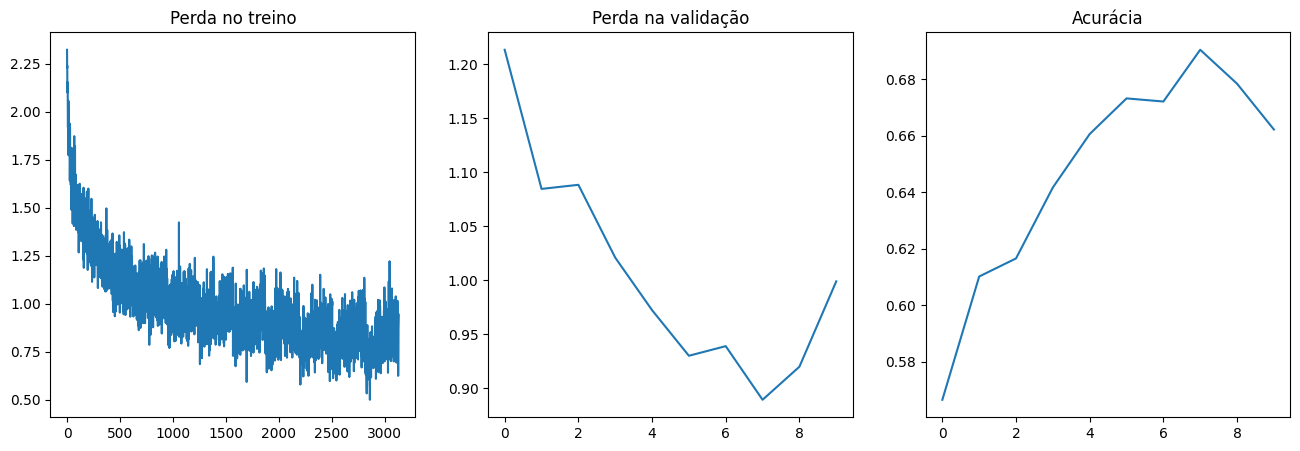

In [5]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 5))
ax1.plot(cnn.train_losses, label="Treino")
ax2.plot(cnn.val_losses, label="Validação")
ax3.plot(cnn.accuracies, label="Acurácia")
ax1.set_title("Perda no treino")
ax2.set_title("Perda na validação")
ax3.set_title("Acurácia")
plt.show()

#### Busca dos melhores hiper-parâmetros

In [6]:
dict_values = {
    "batch_size": [2**i for i in range(6, 9)],
    "lr": [10**-i for i in range(3, 5)],
    "weight_decay": [10**-i for i in range(2, 4)],
    #"dropout_p": [0.1, 0.3, 0.5],
    "c1": [32, 64],
    "c2": [32, 64],
    "kernel_size": [3, 5, 7],
    "l1": [64, 128],
    "l2": [64, 128]
}

In [7]:
best_accuracy = -float('inf')
combinations = list(product(*dict_values.values()))

for parameters in tqdm.tqdm(combinations, desc="Training...", unit="model"):
    params = dict(zip(dict_values.keys(), parameters))
    cnn = CNN(**params).fit(train_set, val_set, show_progress=False)
    test_accuracy = cnn.get_accuracy_and_loss(test_set)[0]
    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
        best_params = params

Training...: 100%|██████████| 576/576 [5:42:21<00:00, 35.66s/model]  


Melhor configuração encontrada:

-    'batch_size': 64
-    'lr': 0.0001
-    'weight_decay': 0.01
-    'c1': 64
-    'c2': 64
-    'kernel_size': 7
-    'l1': 128
-    'l2': 128

Testando a melhor configuração...

In [18]:
cnn = CNN(num_epochs=10, **best_params)
cnn.fit(train_set, val_set, show_progress=True)
#torch.save(cnn.state_dict(), "best_model.pth") # Salva o modelo
print(f'Best accuracy: {cnn.get_accuracy_and_loss(test_set)[0]:.2%}')
print(f'Best combination: {best_params}')

Best accuracy: 72.89%
Best combination: {'batch_size': 64, 'lr': 0.0001, 'weight_decay': 0.01, 'c1': 64, 'c2': 64, 'kernel_size': 7, 'l1': 128, 'l2': 128}


##### Curvas de aprendizado do melhor modelo

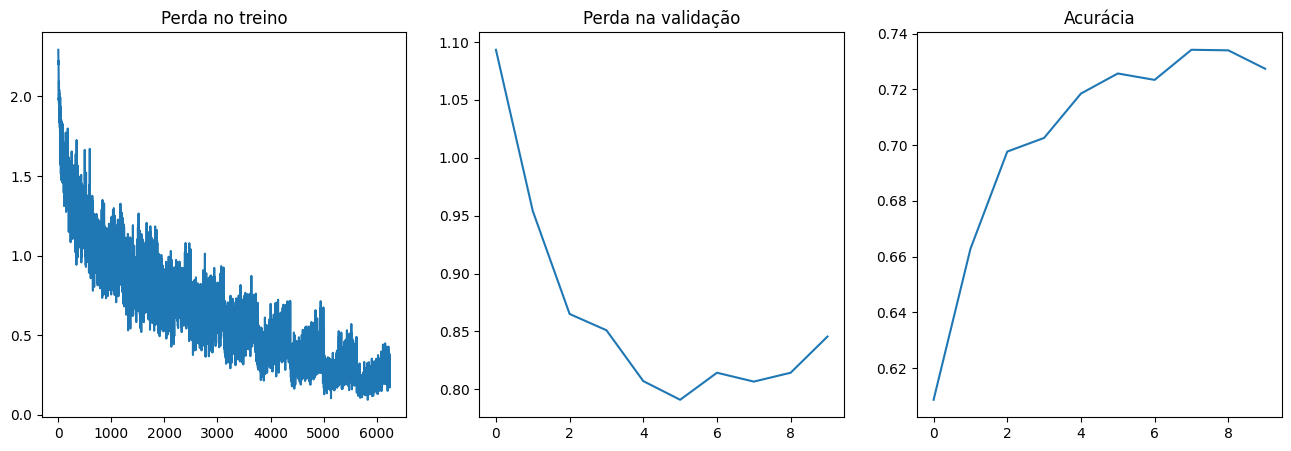

In [19]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 5))
ax1.plot(cnn.train_losses, label="Treino")
ax2.plot(cnn.val_losses, label="Validação")
ax3.plot(cnn.accuracies, label="Acurácia") 
ax1.set_title("Perda no treino")
ax2.set_title("Perda na validação")
ax3.set_title("Acurácia")
plt.show()

In [5]:
#Carrega o modelo salvo
#cnn = CNN(**{'batch_size': 64, 'lr': 0.0001, 'weight_decay': 0.01, 'c1': 64, 'c2': 64, 'kernel_size': 7, 'l1': 128, 'l2': 128})
#cnn.load_state_dict(torch.load("best_model.pth",  map_location=torch.device('cpu')))

<All keys matched successfully>

#### Plots das figuras intermediárias para alguns inputs de escolha
Vamos mostrar como os dados de entrada são transformados ao longo da primeira camada convolucional. 

In [103]:
def plot_features(cnn: CNN, n_label: int, image: torch.Tensor | None = None) -> None:
    # Seleciona uma imagem aleatória da classe n_label
    if image is None:
        images_class = list(input for input, label in test_set if label == n_label)
        n = random.randint(0, len(images_class))
        image = images_class[n].to(device)

    # Plota a imagem original
    plt.figure(figsize=(3,3))
    plt.figure(1)
    plt.imshow((image.cpu().numpy()/2+0.5).transpose(1, 2, 0))
    plt.title('Imagem original', fontsize=10)
    plt.tick_params(axis='both', which='major', labelsize=8)
    plt.show()

    # Seleciona a primeira camada convolucional
    first_conv = cnn[0]
    result = first_conv(image)

    # Mostra as features da primeira camada convolucional
    fig, ax = plt.subplots(4, 8, figsize=(18, 10))
    for i in range(4):
        for j in range(8):
            n = i * 8 + j
            ax[i, j].imshow(result[n].detach().numpy(), cmap="gray")
            ax[i, j].set_title(f"Feature {n}")
            ax[i, j].axis("off")
    plt.show()

    # Mostra a classe prevista pelo modelo
    with torch.no_grad():
        image = image.unsqueeze(0)
        output = cnn(image)
        _, predicted = torch.max(output.data, 1)
        print(f'Classe prevista: {classes[predicted.item()]}')
        real = classes[n_label]
        print(f'Classe real: {real}')

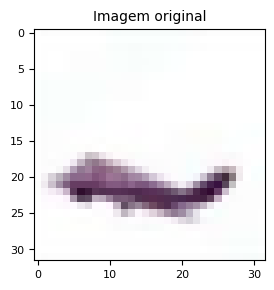

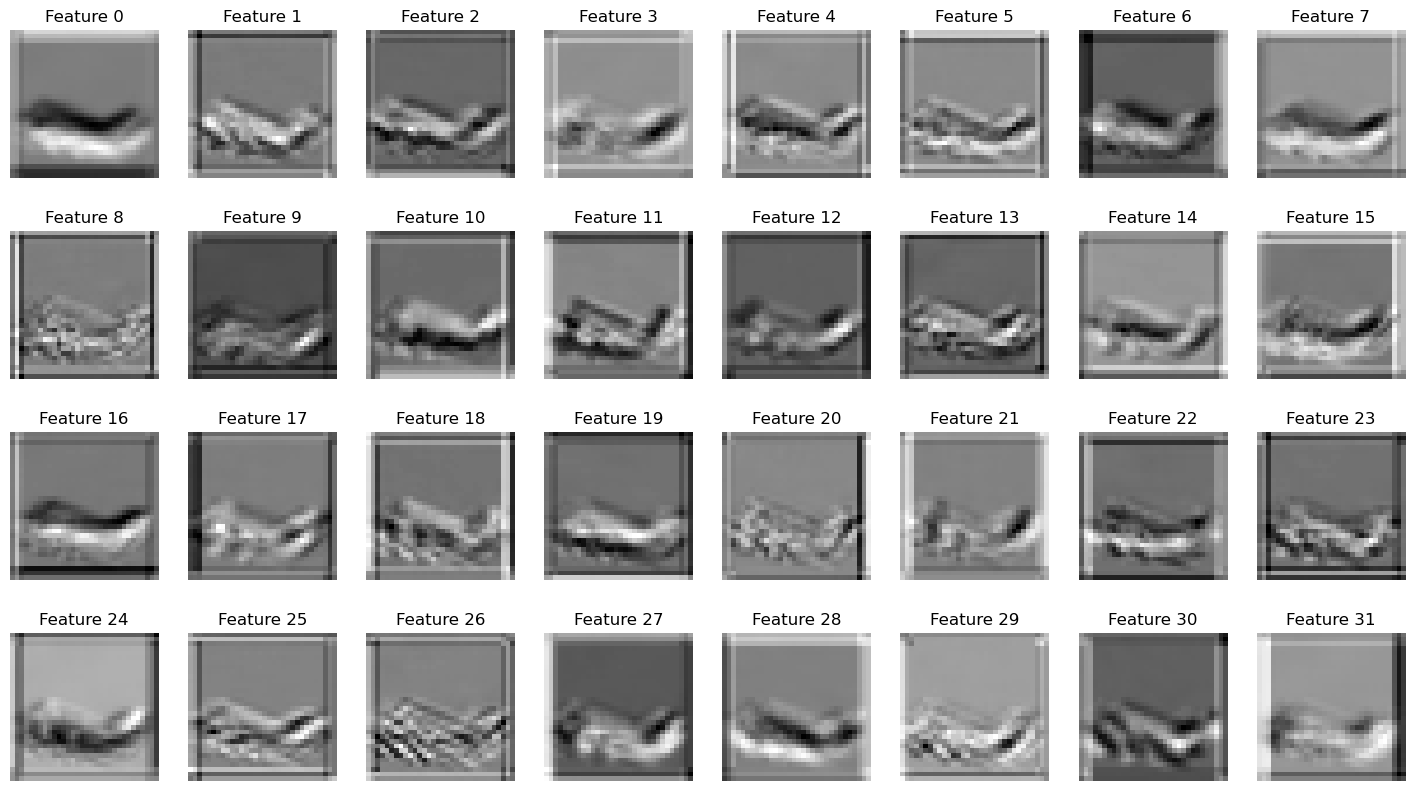

Classe prevista: plane
Classe real: plane


In [104]:
plot_features(cnn, 0) # Avião

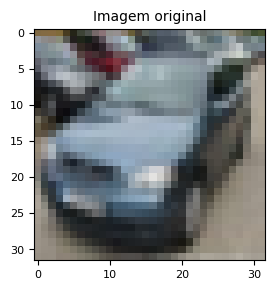

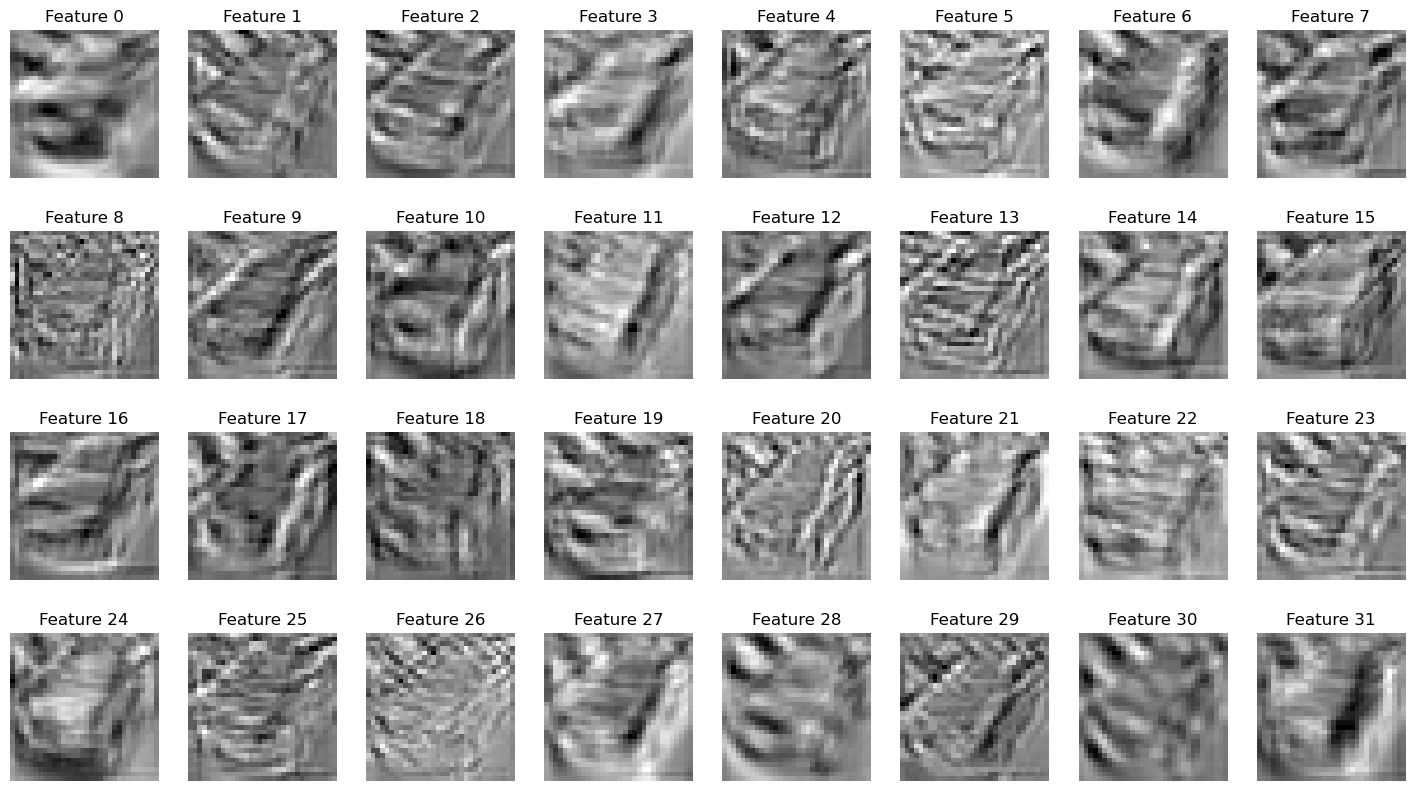

Classe prevista: car
Classe real: car


In [42]:
plot_features(cnn, 1) # Carro

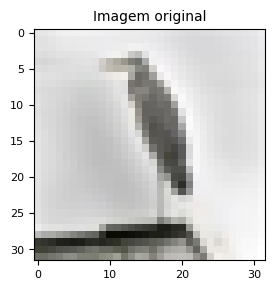

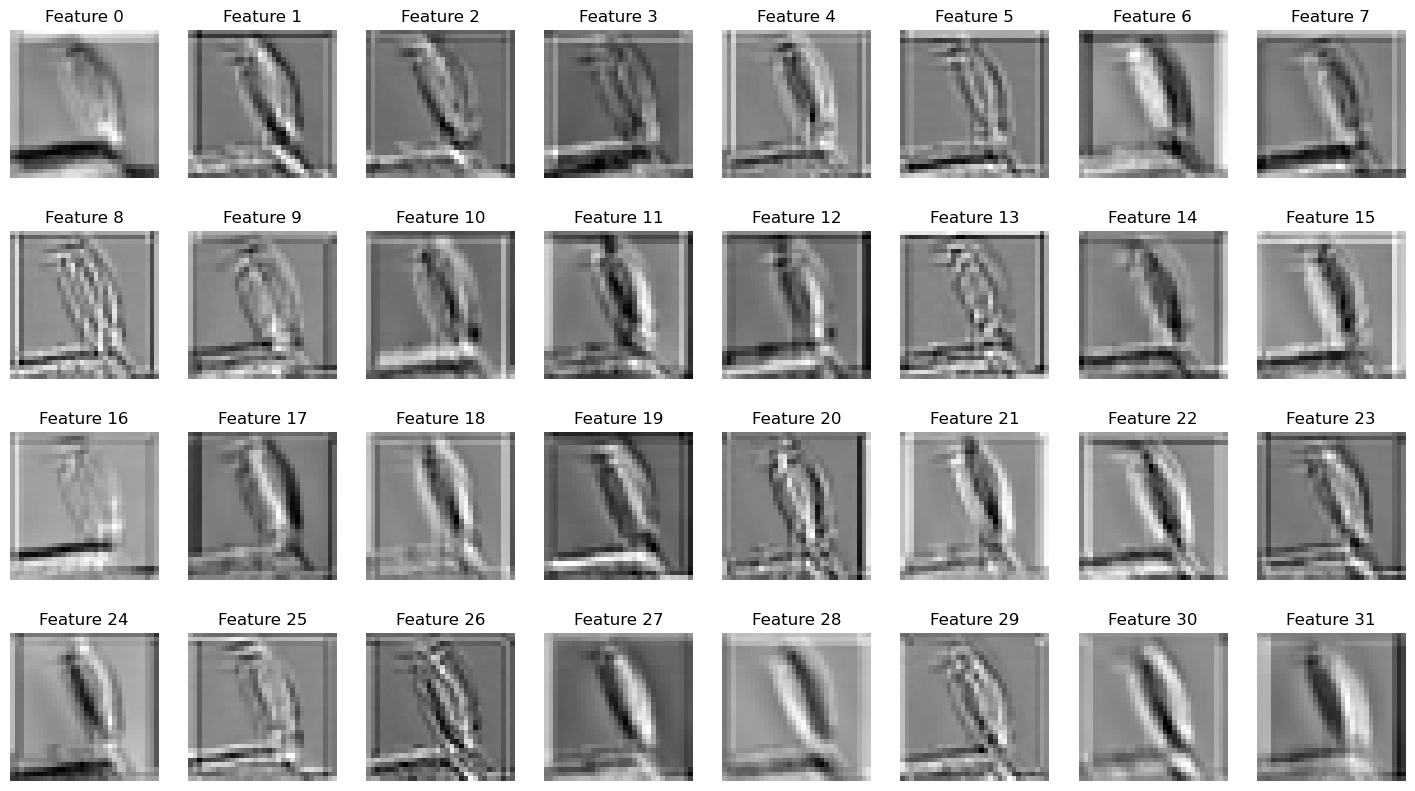

Classe prevista: bird
Classe real: bird


In [46]:
plot_features(cnn, 2) # Pássaro

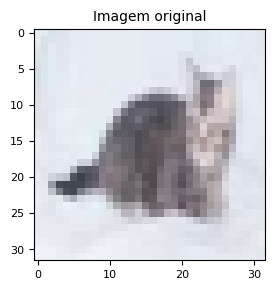

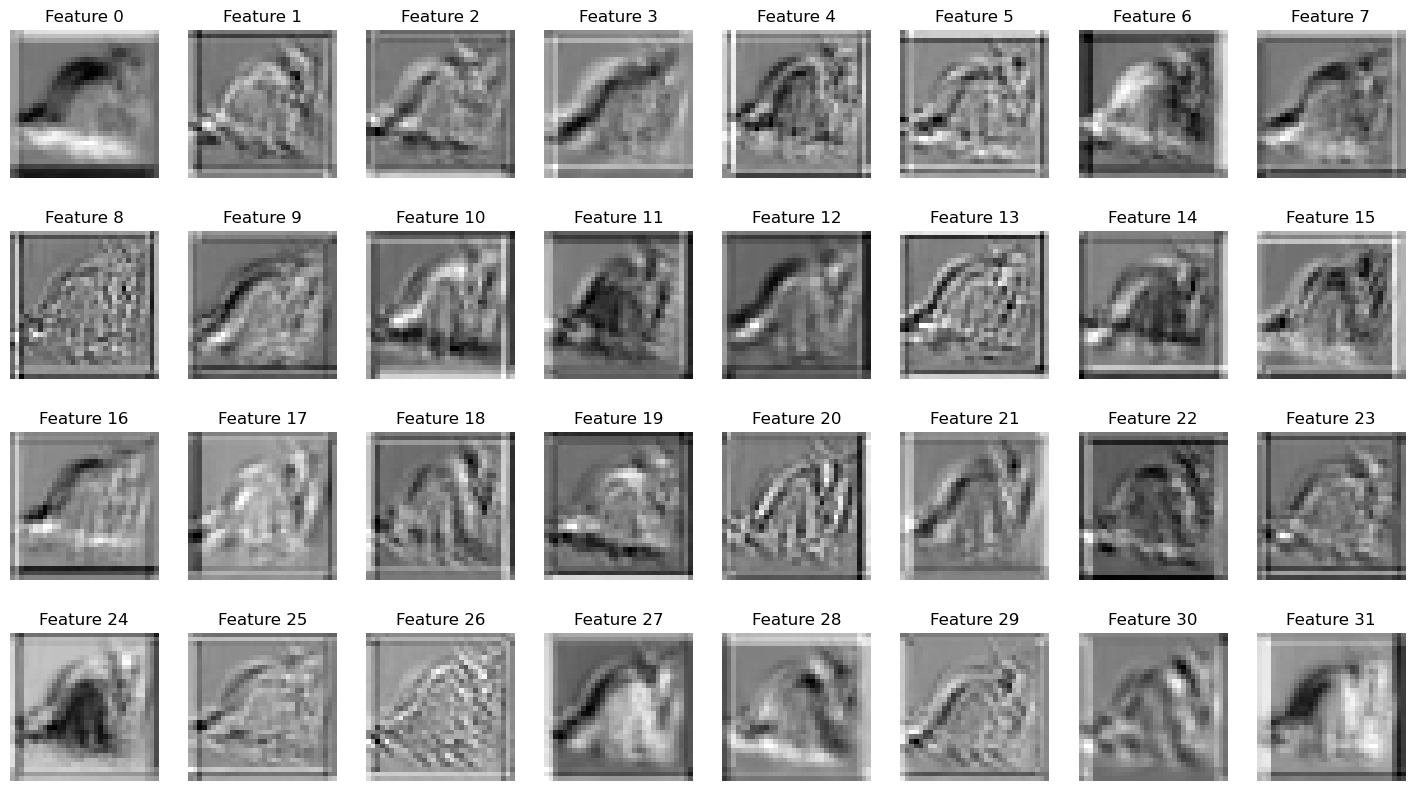

Classe prevista: cat
Classe real: cat


In [52]:
plot_features(cnn, 3) # Gato

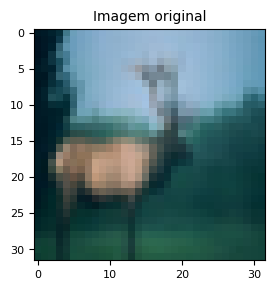

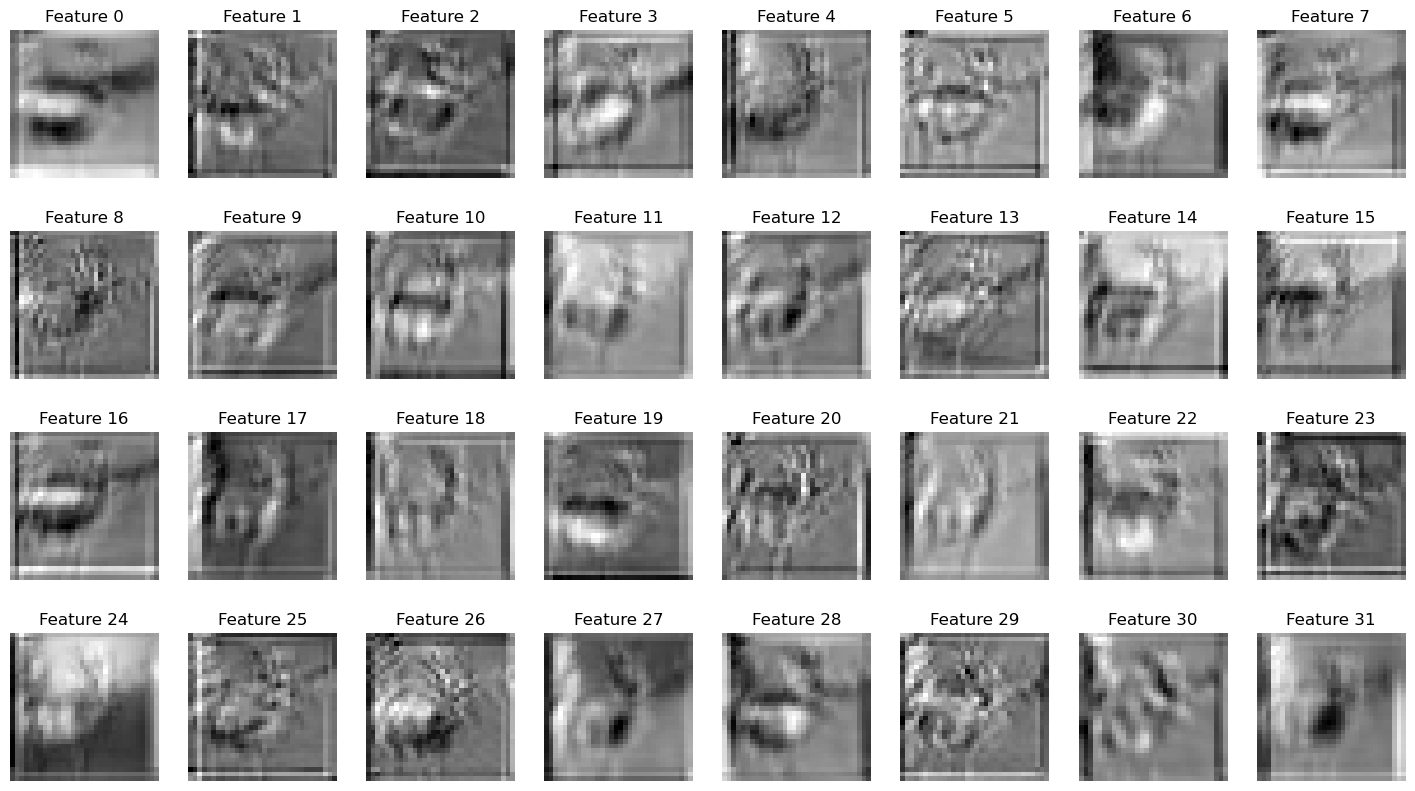

Classe prevista: deer
Classe real: deer


In [47]:
plot_features(cnn, 4) # Veado

Bônus...

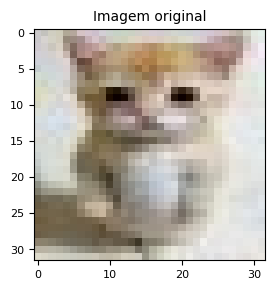

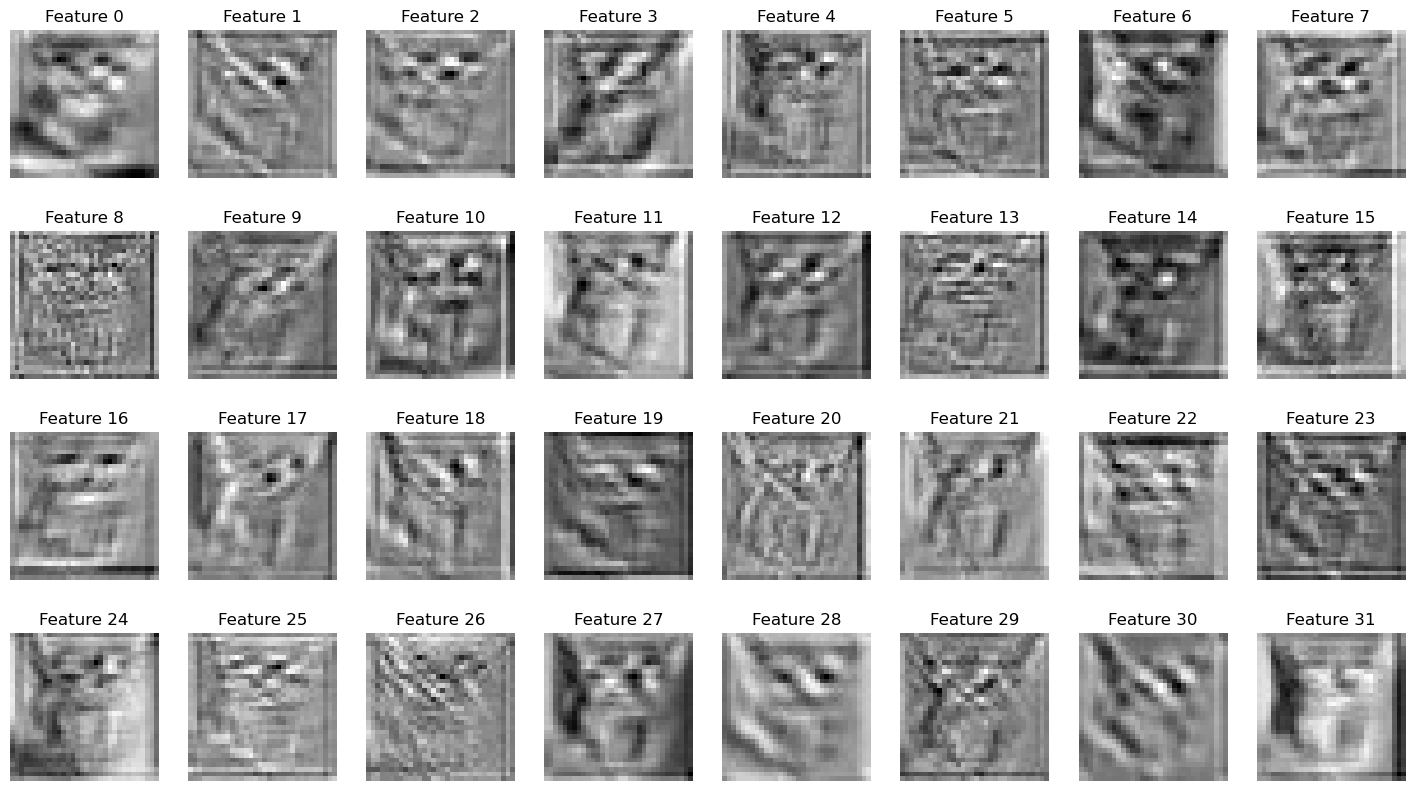

Classe prevista: cat
Classe real: cat


In [107]:
from PIL import Image
img = transform_test(Image.open('el_gato.jpg'))
plot_features(cnn, 3, img)

### Conclusões

Note que os filtros tiveram maior ativação nas bordas das imagens, especialmente em regiões onde há mudanças bruscas de cor. Isso é esperado, pois a primeira camada convolucional é responsável por detectar padrões mais simples. Isso fica visível ao observar o contorno nas asas do avião e do pássaro.

Por último, vamos importar "classification_report" do sklearn.metrics e mostrar o relatório de classificação do modelo no conjunto de teste. Abaixo podemos ver o desempenho do modelo para cada classe, bem como a acurácia média. 

In [67]:
from sklearn.metrics import classification_report
# Imprime o relatório de classificação
print(classification_report(test_set.targets, cnn.predict(test_set), target_names=classes))

              precision    recall  f1-score   support

       plane       0.76      0.77      0.77      1000
         car       0.83      0.81      0.82      1000
        bird       0.64      0.58      0.61      1000
         cat       0.58      0.44      0.50      1000
        deer       0.65      0.69      0.67      1000
         dog       0.69      0.57      0.62      1000
        frog       0.61      0.89      0.73      1000
       horse       0.76      0.79      0.78      1000
        ship       0.87      0.81      0.84      1000
       truck       0.78      0.82      0.80      1000

    accuracy                           0.72     10000
   macro avg       0.72      0.72      0.71     10000
weighted avg       0.72      0.72      0.71     10000



Pela tabela acima, podemos ver que o modelo teve um desempenho melhor para classificar aviões, carros e navios. Por outro lado, o modelo teve um desempenho pior para classificar gatos, cães e sapos, provavelmente devido a semelhança entre certas características dessas classes. A acurácia média do modelo foi de 0.72.

# Exercício de "papel e caneta"

**1.** Na aula discutimos como CNNs podem ser vistas como casos especiais de MLPs. Com isso em mente, mostre que 
1) camadas convolucionais podem ser escritas como uma transformação linear seguida por uma transformação não linear; e 
2) camadas de pooling de média ou soma podem ser escritas como transformações lineares. 

**Resposta: 1.**

 Uma camada convolucional em uma rede neural convolucional (CNN) pode ser decomposta em duas partes principais: uma operação de convolução (transformação linear) seguida por uma função de ativação (transformação não linear).

A operação de convolução é uma operação linear que consiste em multiplicar um filtro (ou kernel) pela imagem de entrada, pixel a pixel, e somar os resultados.

Seja a entrada $X$ um vetor ou matriz, no caso mais simples de uma convolução unidimensional, teríamos:

$$Y = X \ast W $$

Onde $Y$ é a saída da operação de convolução, $W$ é o filtro e $\ast$ é o operador de convolução. Essa operação é linear porque é uma combinação linear dos elementos da entrada e pode ser escrita como uma multiplicação de matrizes $Y = W \cdot X$.

No caso de uma convolução bidimensional, a operação é análoga, mas a entrada e o filtro são matrizes bidimensionais. Essa transformação é dada por:

$$
S(i,j) = (X \ast W)(i,j) = \sum_{m} \sum_{n} X(i+m, j+n) \cdot W(m,n) 
$$

Onde,
- $X$ é nossa matriz de entradas, que possui linhas $i$ e colunas $j$,
- $W$ é um kernel também bidimensional
- $S(i,j)$ é a entra $i,j$ da matrix de saída resultante da operação de convolução

Note que podemos dizer que fazemos uma transformação linear porque estamos essencialmente combinando as entradas de $X$, nosso input, e essa relação é válida para qualquer dimensionalidade atribuída a 
$X$ (e consequentemente a K). 

Após a convolução, aplicamos uma função de ativação não linear $\sigma$,

$$ Z = \sigma(Y) $$

Tal que $Z = max(0, Y)$, se $\sigma$ for a função ReLU. Portanto, a camada convolucional pode ser escrita como uma transformação linear seguida por uma transformação não linear.

$$ Z = \sigma(W \ast X) $$

**Resposta: 2.**

Uma camada de pooling média ou soma é uma operação que reduz a dimensionalidade da entrada, mantendo as características mais importantes. No pooling de média, dividimos a entrada em regiões não sobrepostas e calculamos a média dos valores em cada região. Suponha que a entrada $X$ seja uma matriz bidimensional, e que a operação de pooling seja feita em regiões de tamanho $k \times k$. A operação de pooling de média é dada por:

$$ Y(i,j) = \frac{1}{k^2} \sum_{m=0}^{k-1} \sum_{n=0}^{k-1} X(i \cdot k + m, j \cdot k + n) $$

Essa operação é uma média ponderada onde cada peso é $\frac{1}{k^2}$. Portanto, podemos escrever essa operação como uma multiplicação de matrizes onde a matriz de pooling tem $\frac{1}{k^2}$ em posições específicas e 0s em todas as outras posições. Logo, o pooling de média pode ser escrito como uma transformação linear.

Analogamente, no pooling de soma a operação é semelhante, mas em vez de calcular a média dos valores em cada região, calculamos a soma.

$$ Y(i,j) = \sum_{m=0}^{k-1} \sum_{n=0}^{k-1} X(i \cdot k + m, j \cdot k + n) $$

Aqui, os pesos são simplesmente 1 em cada posição da janela de pooling. Então podemos escrever essa operação como uma multiplicação matricial onde a matriz de pooling tem 1s em posições específicas e 0s em todas as outras posições. Logo, tanto o pooling de média quanto o pooling de soma podem ser escritos como transformações lineares, pois envolvem a aplicação de uma matriz de pesos sobre a entrada de forma linear.

**2.** Criar modelos invariantes a transformações específicas das suas entradas é um tópico quente em machine learning. Por exemplo, suponha que queremos prever propriedades de um grafo $G$ de $n$ nós, com matriz de adjacência $A \in \{0,1\}^{n \times n}$ e em que cada nó $i=1,\ldots,n$ é anotado com um vetor de features $x_i \in \mathbb{R}^d$. Seja também $X = [x_1, \ldots, x_n]^\intercal$ a matriz de features dos nós.

Note também que um grafo com features de nó pode ser descrito como uma tupla $(X, A)$ sem perda de generalidade. Nesse caso, gostaríamos que nossa rede neural $f$ produzisse o mesmo output para grafos identicos (i.e., fosse invariante a isomorfismo). Dizemos que dois grafos $G=(X, A)$ e $G^\prime=(X^\prime, A^\prime)$ são isomorfos se existe uma matriz de permutação $P \in \{0,1\}^{n \times n} : \forall_i \sum_i P_{ij} = 1, \forall_j \sum_j P_{ij} = 1 $ tal que $X^\prime = P X$ e $A^\prime = P A P^\intercal$.

Existe uma classe de redes neurais desenhadas especialmente para serem invariantes a isomorfismo: _graph neural networks_ (GNNs). A mais famosa dessas redes é chamada [_graph convolutional network_ (GCN)](https://arxiv.org/abs/1609.02907). O funcionamento de uma GCN de $L$ camadas para classificação de propriedades de grafos pode ser descrito como:
\begin{align}
&\hat{y} = \textrm{Softmax}\left(\frac{1}{n} \sum_{i=1}^n H^{(L)}_{i:}\right)\\
&H^{(\ell)} = \textrm{ReLU}(\tilde{A}H^{(\ell-1)} W^{(\ell)}) \qquad \forall \ell=1,\ldots,L\\
&H^{(0)} = X
\end{align}
onde $W^{(\ell)} \in \mathbb{R^{d_{\ell-1} \times d_{\ell}}}$ são matrizes de peso, com $d_0 = d$ e $d_L$ sendo o número de classes do nosso problema de classificação. Além disso, $\tilde{A} = D^{-1/2}(A + I)D^{-1/2}$ onde $D$ é uma matriz diagonal com $D_{ii}$ contendo o grau do nó $i$.

**Prove que a GCN descrita acima produz o mesmo valor para qualquer grafo isomorfo a $G=(X, A)$.**

Se você estiver interessado em aprender o básico sobre GNNs, esse vídeo é um bom começo: https://www.youtube.com/watch?v=8owQBFAHw7E (não é necessário para resolver essa questão).

(Dica: Mostre antes que se $P$ é uma matriz de permutação, então $P^\intercal P = I$.)

##### **Resposta:**

Vamos seguir a dica e mostrar que $P^T P  = I$. $P$ é uma matriz de permutação, logo é uma matriz composta por zeros um único 1 em cada linha e em cada coluna. Então temos que:

$$(P P^T)_{ij} = \sum_{k=1}^n P_{ik} P_{kj}^T = \sum_{k=1}^n P_{ik} P_{jk}$$

- Se $i \neq j$, então $P_{ik} P_{jk} = 0$ para todo $k$, pois $P$ tem um único 1 em cada linha e em cada coluna. Portanto, $(P P^T)_{ij} = 0$ para $i \neq j$. 
- Se $i = j$, então $(P P^T)_{ii} = \sum_{k=1}^n P_{ik} P_{ik} = \sum_{k=1}^n P_{ik}^2 = 1$, pois $P$ tem um único 1 em cada linha e em cada coluna. Portanto, $(P P^T)_{ii} = 1$ para $i = j$.

Isso é nada menos que a definição de uma matriz identidade, o que conclui a prova de que $P^T P = I$.

Agora seja $G'= (X', A')$ um grafo isomorfo a $G=(X,A)$, onde $X' = PX$ e $A' = PAP^T$. Vamos mostrar que a GCN produz o mesmo valor para $G$ e $G'$.

$$\begin{align} Ã' &= D'^{-1/2}(A' + I)D'^{-1/2} \\
 &= (PDP^T)^{-1/2}(PAP^T + I)(PDP^T)^{-1/2} \\
 &= PD^{-1/2}P^T(PAP^T + I)PD^{-1/2}P^T \\
    &= PD^{-1/2}\underbrace{P^TP}_{I}A\underbrace{P^TP}_{I}D^{-1/2}P^T + PD^{-1/2}\underbrace{P^TP}_{I}D^{-1/2}P^T \\
\end{align}$$

Pela prova anterior, temos que $P^TP = I$, então:

$$\begin{align} Ã' &= PD^{-1/2}AD^{-1/2}P^T + PD^{-1/2}D^{-1/2}P^T \\
 &= PD^{-1/2} (A + I)D^{-1/2}P^T \\
    &= PÃP^T
\end{align}$$

Substituindo $Ã'$ na equação da GCN:

$$\begin{align} \hat{y}' &= \textrm{Softmax}\left(\frac{1}{n} \sum_{i=1}^n H^{'(L)}_{i:}\right) \\
H^{'(l)}&= \textrm{ReLU}(\tilde{A'}H^{(l-1)} W^{(l)}) \qquad \forall l=1,\ldots,L\\
H^{'(0)} &= X' = PX
\end{align}$$

Agora vamos mostrar que $\hat{y} = \hat{y}'$. Para isso, vamos mostrar por indução que $H^{'(l)} = PH^{(l)}$ para todo $l=1,\ldots,L$. No caso base, para $l=1$ temos:

$$\begin{align} H^{'(1)} &= \textrm{ReLU}(\tilde{A'}H^{(0)} W^{(1)}) \\
 &= \textrm{ReLU}(\tilde{A'}PX W^{(1)}) \\
 &= \textrm{ReLU}(PÃP^TPX W^{(1)}) \\
 &= \textrm{ReLU}(PÃX W^{(1)}) \\
 &= \textrm{ReLU}(PÃH^{(0)} W^{(1)}) \\
 &= PH^{(1)}
\end{align}$$

Agora, suponha que $H^{'(l)} = PH^{(l)}$ para algum $l \in \{1, \ldots, L-1\}$. Analogamente, vamos mostrar que $H^{'(l+1)} = PH^{(l+1)}$:

$$\begin{align} H^{'(l+1)} &= \textrm{ReLU}(\tilde{A'}H^{(l)} W^{(l+1)}) \\
 &= \textrm{ReLU}(\tilde{A'}PH^{(l)} W^{(l+1)}) \\
 &= \textrm{ReLU}(PÃPH^{(l)} W^{(l+1)}) \\
 &= \textrm{ReLU}(PÃH^{(l)} W^{(l+1)}) \\
 &= \textrm{ReLU}(PÃH^{(l)} W^{(l+1)}) \\
 &= PH^{(l+1)}
\end{align}$$

Portanto, temos que $H^{'(L)} = PH^{(L)}$. Substituindo na equação de $\hat{y}'$:

$$\begin{align} \hat{y}' &= \textrm{Softmax}\left(\frac{1}{n} \sum_{i=1}^n H^{'(L)}_{i:}\right) \\
 &= \textrm{Softmax}\left(\frac{1}{n} \sum_{i=1}^n PH^{(L)}_{i:}\right) \\
 &= \textrm{Softmax}\left(P\frac{1}{n} \sum_{i=1}^n H^{(L)}_{i:}\right) \\
 &= \textrm{Softmax}\left(\frac{1}{n} \sum_{i=1}^n H^{(L)}_{i:}\right) \\
 &= \hat{y}
\end{align}$$

Pois $H^{'(L)} = PH^{(L)}$. Concluindo, a GCN produz o mesmo valor para qualquer grafo isomorfo a $G=(X,A)$.
